# SLT-CE-2: Deterministic Annealing

### References

<ol>
<li> Sections II.A.1 (principled derivation of deterministic annealing) and II.A.3 (Mass-constrained clustering) of 'Deterministic annealing for clustering, compression, classification, regression, and related optimization problems', Kenneth Rose, 1998, http://ieeexplore.ieee.org/document/726788/ 
</li>

<li>
The wine data set, http://www3.dsi.uminho.pt/pcortez/wine5.pdf
</li>
    
</ol>

### Setup 

In [1]:
import sklearn as skl
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import sklearn.svm as svm
from sklearn import cluster
import random

import pandas as pd
import numpy as np
from treelib import Tree

import matplotlib.pyplot as plt
from matplotlib import cm

<h2 style="background-color:#f0b375;">
Section 4.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.0 </span>
</h2>

<p style="background-color:#adebad;">
    For this exercise, it is of utmost importance to read reference [1] about deterministic annealing clustering (DAC). Our implementation will be based on this reference. Please shortly summarize what they refer to as the <i>preferred implementation</i> of the DAC algorithm.
</p>

The autho refer to the Mass-Constrained Clustering as the preferred implementation of the DAC algorithm. In this method we add weights to centroids. We only provide new centroids if deemed necessary, which leads to keeping only an effective number of clusters for a given T. This approach allows us to overcome the issue of the DA algorithm's dependence on the number of coincident codevectors in each effective cluster, leading to a method that is entirely independent of initialization. 

The mass-constrained algorithm requires only as many codevectors as there are effective clusters at a given temperature, making it computationally efficient. The model size is increased only when necessary, i.e., when a critical temperature is reached. The mechanism can be implemented by perturbing pairs of codevectors at each effective cluster to separate only when a phase transition occurs. Alternatively, an additional codevector can be supplied when the critical temperature is reached.


At the limit of low temperature, both the unconstrained DA method and the mass-constrained DA method converge to the same descent process. The difference between the two is in their behavior at intermediate temperatures, where the mass-constrained clustering method takes the cluster populations into account.



<p style="background-color:#adebad;">
    In order to avoid headaches with numerical instabilities, we first try our algorithm on a simple artificially generated data as below. Run the bloc below to have a look at the data. Later when we have everything implemented, we will examine some real world data. 
</p>

Text(0.5, 1.0, 'Test data')

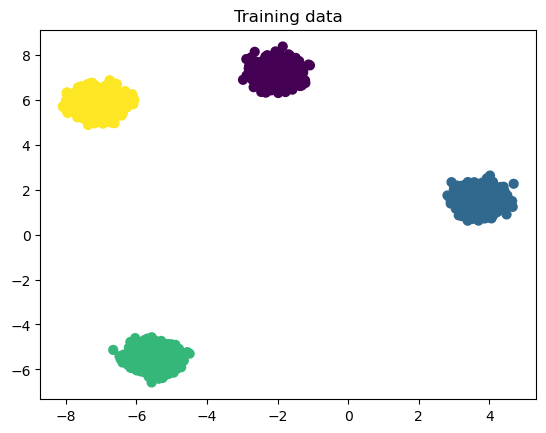

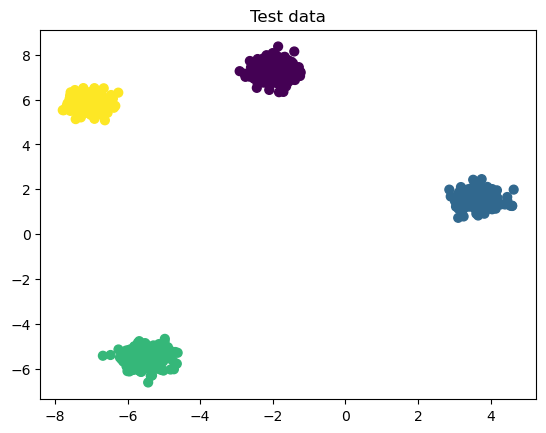

In [2]:
n_clusters = 4
ran_s = 42

# Generate artificial dataset
X, y_true = make_blobs(n_samples=7000, centers=4,
                       cluster_std=0.3, random_state=ran_s,
                       center_box=(-8.0, 8.0),
                       shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, train_size=6000, random_state=42)

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, cmap='viridis')
plt.title("Training data")

plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap='viridis')
plt.title("Test data")

<p style="background-color:#adebad;">
    Implement the <b>fit method</b> for the template class DeterministicAnnealing, according to the contract outlined in its docstring. (The template class DeterministicAnnealing is in file <b>DA.py</b> which you can open in your favourite IDE) For the implementation, it may help to take a look at both <b>get_distance method</b> and <b>fit _calculate_cluster_probs method</b> and implement them as well. Of course you are free to change all these methods or/and write additional methods for your purpose.
    You can add more class methods as necessary.
    See http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html for complementary information.
</p>
<p style="background-color:#adebad;">
    While implementing, you can run the bloc below to test your implementation.
</p>

In [3]:



def read_data_csv(sheet, y_names=None):
    """Parse a column data store into X, y arrays

    Args:
        sheet (str): Path to csv data sheet.
        y_names (list of str): List of column names used as labels.

    Returns:
        X (np.ndarray): Array with feature values from columns that are not
        contained in y_names (n_samples, n_features)
        y (dict of np.ndarray): Dictionary with keys y_names, each key
        contains an array (n_samples, 1) with the label data from the
        corresponding column in sheet.
    """

    data = pd.read_csv(sheet)
    feature_columns = [c for c in data.columns if c not in y_names]
    X = data[feature_columns].values
    y = dict([(y_name, data[[y_name]].values) for y_name in y_names])

    return X, y


class DeterministicAnnealingClustering(skl.base.BaseEstimator,skl.base.TransformerMixin):
    """Template class for DAC

    Attributes:
        cluster_centers (np.ndarray): Cluster centroids y_i
            (n_clusters, n_features)
        cluster_probs (np.ndarray): Assignment probability vectors
            p(y_i | x) for each sample (n_samples, n_clusters)
        bifurcation_tree (treelib.Tree): Tree object that contains information
            about cluster evolution during annealing.

    Parameters:
        n_clusters (int): Maximum number of clusters returned by DAC.
        random_state (int): Random seed.
    """

    def __init__(self, n_clusters=8, random_state=42, metric="euclidian", T_min=0.1, eta=0.98, epsilon = 0.1, T=1e-5):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.metric = metric
        self.T = T
        self.T_min = T_min

        self.cluster_centers = None
        self.cluster_probs = None

        self.n_eff_clusters = list()
        self.temperatures = list()
        self.distortions = list()
        self.bifurcation_tree = Tree()

        # Not necessary, depends on your implementation
        self.bifurcation_tree_cut_idx = None

        # Add more parameters, if necessary. You can also modify any other
        # attributes defined above
        self.eta = eta
        self.epsilon = epsilon
        
    def initialize_tree(self, n_features, T):
        self.tr_references = [self.cluster_centers[0]]
        self.tr_dirs = [1]
        self.tr_dists = [[] for x in range(self.n_clusters)]
        self.tr_temps = [[] for x in range(self.n_clusters)]
        self.tr_dists[0].append(self.tr_dirs[0] * (np.linalg.norm(self.tr_references[0] - self.cluster_centers[0])))
        self.tr_temps[0].append(T)
        self.tr_offs = [0.0]

    def fit(self, samples):
        """Compute DAC for input vectors X

        Preferred implementation of DAC as described in reference [1].

        Args:
            samples (np.ndarray): Input array with shape (samples, nfeatures)
        """

        self.bifurcation_tree.create_node(0, '0_0')


        nsamples, nfeatures = samples.shape

        yinit = np.mean(samples, axis=0)
        m = 1
        self.cluster_centers = np.repeat(yinit[np.newaxis,:], m, axis=0)
        self.cluster_pb = np.ones((nsamples, m), dtype='float32') / m
        self.pylist = np.ones((m, 1), dtype='float32') / m

        T = self.critical_temperature( 0, 1.0 / nsamples, samples) * 1.001

        self.initialize_tree(nfeatures, T)
        

        while True:
            if m == self.n_clusters:
                self.eta = 0.95

            for i in range(0,m):
                for j in range(i+1,m):
                    if np.linalg.norm(self.cluster_centers[i] - self.cluster_centers[j]) < self.epsilon:
                        noise = np.squeeze(np.random.normal(0, self.epsilon, nfeatures))
                        self.cluster_centers[j] += noise
                        self.cluster_centers[i] -= noise


            while True:
                yold = self.cluster_centers.copy()
                self.cluster_pb = np.ones((nsamples, m), dtype='float32') / m

                diffs = np.array([np.linalg.norm(samples-self.cluster_centers[k], axis=1)**2 / T for k in range(m)])
                cs = np.exp(-diffs + np.min(diffs, axis=0, keepdims=True)) * self.pylist
                self.cluster_pb = np.moveaxis(cs / np.sum(cs, axis=0), 0, 1)


                self.pylist = []
                for k in range(m):
                    p_given_x = np.expand_dims(self.cluster_pb[:,k],axis=1)
                    p_y = np.sum(p_given_x) * 1.0 / nsamples
                    self.pylist.append(p_y)
                    temp = np.sum(p_given_x * samples, axis=0)
                    self.cluster_centers[k] = (temp / nsamples) / p_y
                self.pylist = np.expand_dims(self.pylist, axis=1)

                if np.linalg.norm(yold - self.cluster_centers) < 1e-4:
                    break

            if T == self.T:
                break

            if T < self.T_min:
                T = self.T
                continue

            distortions, e = self.distortion_free_energy(samples, m)
            self.distortions.append(distortions)
            self.n_eff_clusters.append(m)
            self.temperatures.append(T)

            T = T * self.eta

            if m < self.n_clusters:
                for k in range(0, m):

                    T_c = self.critical_temperature( k, 1.0 / nsamples, samples)

                    if T < T_c and m < self.n_clusters and self.pylist[k,:] > 1.0/self.n_clusters:
                        noise = np.random.normal(0, self.epsilon, nfeatures)
                        new_centroid = np.expand_dims(self.cluster_centers[k] + np.squeeze(noise), axis=0)
                        self.cluster_centers = np.vstack((self.cluster_centers, new_centroid))

                        self.pylist = self.pylist[:,0]
                        self.pylist = np.append(self.pylist, [self.pylist[k]/2])
                        self.pylist[k] = self.pylist[k]/2
                        m += 1
                        self.pylist = np.expand_dims(self.pylist, axis=1)

                        self.tr_dirs[k] = -1
                        self.tr_dirs.append(1)
                        self.tr_references[k] = self.cluster_centers[k].copy()
                        self.tr_references.append(self.cluster_centers[k].copy())
                        dist = np.linalg.norm(self.tr_references[k] - self.cluster_centers[k])
                        self.tr_offs[k] = self.tr_dists[k][-1]
                        self.tr_offs.append(self.tr_dists[k][-1])

                        self.tr_dists[k].append(self.tr_offs[k] + self.tr_dirs[k] * dist)
                        self.tr_temps[k].append(T)

                        self.tr_dists[m-1].append(self.tr_offs[k] + self.tr_dirs[k] * dist)
                        self.tr_temps[m-1].append(T)
                    else:
                        dist = np.linalg.norm(self.tr_references[k] - self.cluster_centers[k])
                        self.tr_dists[k].append(self.tr_offs[k] + self.tr_dirs[k] * dist)
                        self.tr_temps[k].append(T)
            else:
                for k in range(m):
                    dist = np.linalg.norm(self.tr_references[k] - self.cluster_centers[k])
                    self.tr_dists[k].append(self.tr_offs[k] + self.tr_dirs[k] * dist)
                    self.tr_temps[k].append(T)


        d, self.free_energy = self.distortion_free_energy(samples, m)
        print('free energy', self.free_energy)

        self.distortions = np.array(self.distortions, dtype='float32')
        self.n_eff_clusters = np.array(self.n_eff_clusters, dtype='float32')
        self.temperatures = np.array(self.temperatures, dtype='float32')

        return self


    def _calculate_cluster_probs(self, samples, dist_mat, temperature):
        """Predict assignment probability vectors for each sample in X given
            the pairwise distances

        Args:
            dist_mat (np.ndarray): Distances (n_samples, n_centroids)
            temperature (float): Temperature at which probabilities are
                calculated

        Returns:
            probs (np.ndarray): Assignment probability vectors
                (new_samples, n_clusters)
        """
        
        probs = np.zeros((samples.shape[0], self.n_clusters))
        d = np.zeros((samples.shape[0], ))
        for k in range(0, self.n_clusters):
            cost = self.pylist[k] * np.exp(-dist_mat[k] + np.squeeze(np.min(dist_mat, axis=0, keepdims=True))  )
            probs[:,k] = cost
            d += cost
        d = np.expand_dims(d, axis=1)
        probs = np.divide(probs, d)
        
        return probs

    def get_distance(self, samples, clusters):
        """Calculate the distance matrix between samples and codevectors
        based on the given metric

        Args:
            samples (np.ndarray): Samples array (n_samples, n_features)
            clusters (np.ndarray): Codebook (n_centroids, n_features)

        Returns:
            D (np.ndarray): Distances (n_samples, n_centroids)
        """
        D = np.array([np.linalg.norm(samples-self.cluster_centers[k], axis=1)**2 /0.1 for k in range(self.n_clusters)])
        return D

    def predict(self, samples):
        """Predict assignment probability vectors for each sample in X.

        Args:
            samples (np.ndarray): Input array with shape (new_samples, n_features)

        Returns:
            probs (np.ndarray): Assignment probability vectors
                (new_samples, n_clusters)
        """
        distance_mat = self.get_distance(samples, self.cluster_centers)
        probs = self._calculate_cluster_probs(samples, distance_mat, self.T_min)
        return probs

    def transform(self, samples):
        """Transform X to a cluster-distance space.

        In the new space, each dimension is the distance to the cluster centers

        Args:
            samples (np.ndarray): Input array with shape
                (new_samples, n_features)

        Returns:
            Y (np.ndarray): Cluster-distance vectors (new_samples, n_clusters)
        """
        check_is_fitted(self, ["cluster_centers"])

        distance_mat = np.linalg.norm(samples[:, np.newaxis, :] - self.cluster_centers[np.newaxis, :, :], axis=-1)
        return distance_mat

    def plot_bifurcation(self):
        """Show the evolution of cluster splitting

        This is a pseudo-code showing how you may be using the tree
        information to make a bifurcation plot. Your implementation may be
        entire different or based on this code.
        """
        check_is_fitted(self, ["bifurcation_tree"])

        clusters = [[] for _ in range(len(np.unique(self.n_eff_clusters)))]
        for node in self.bifurcation_tree.all_nodes_itr():
            print(node.data)
            c_id = node.data['cluster_id']
            my_dist = node.data['distance']

            if c_id > 0 and len(clusters[c_id]) == 0:
                clusters[c_id] = list(np.copy(clusters[c_id-1]))
            clusters[c_id].append(my_dist)

        cut_idx = self.bifurcation_tree_cut_idx + 20

        beta = [1 / t for t in self.temperatures]
        plt.figure(figsize=(10, 5))
        for c_id, s in enumerate(clusters):
            plt.plot(s[:cut_idx], beta[:cut_idx], '-k',
                     alpha=1, c='C%d' % int(c_id),
                     label='Cluster %d' % int(c_id))
        plt.legend()
        plt.xlabel("distance to parent")
        plt.ylabel(r'$1 / T$')
        plt.title('Bifurcation Plot')
        plt.show()
    

    def critical_temperature(self, k, p, X):
        mask = np.array(self.cluster_pb.max(axis=1,keepdims=1) == self.cluster_pb, dtype=int)[:,k]
        deltas = (np.moveaxis(X - self.cluster_centers[k], 0, 1)*np.sqrt(self.cluster_pb[:,k]))*mask
        covar = np.dot(deltas, deltas.T)*p/self.pylist[k,:]
        w, v = np.linalg.eigh(covar)
        T_c = 2*np.max(w)
        return T_c
    
    
    def plot_phase_diagram(self):
        """Plot the phase diagram

        This is an example of how to make phase diagram plot. The exact
        implementation may vary entirely based on your self.fit()
        implementation. Feel free to make any modifications.
        """
        t_max = np.log(max(self.temperatures))
        d_min = np.log(min(self.distortions))
        y_axis = [np.log(i) - d_min for i in self.distortions]
        x_axis = [t_max - np.log(i) for i in self.temperatures]

        plt.figure(figsize=(12, 9))
        plt.plot(x_axis, y_axis)

        region = {}
        for i, c in list(enumerate(self.n_eff_clusters)):
            if c not in region:
                region[c] = {}
                region[c]['min'] = x_axis[i]
            region[c]['max'] = x_axis[i]
        for c in region:
            if c == 0:
                continue
            plt.text((region[c]['min'] + region[c]['max']) / 2, 0.2,
                     'K={}'.format(c), rotation=90)
            plt.axvspan(region[c]['min'], region[c]['max'], color='C' + str(int(c)),alpha=0.2)
        plt.title('Phases diagram (log)')
        plt.xlabel('Temperature')
        plt.ylabel('Distortion')
        plt.show()

        
   
    def distortion_free_energy(self, X, num_centroids):
        dists = np.array([np.linalg.norm(X - self.cluster_centers[k], axis=1)**2 / self.T_min for k in range(num_centroids)])
        jt= self.cluster_pb * 1.0 / X.shape[0]
        D = np.sum(jt * np.moveaxis(dists, 0, 1))
        E = D - (-np.sum(jt * np.log(jt + 1e-8)))*self.T_min
        return D, E


free energy 0.9285051817827396


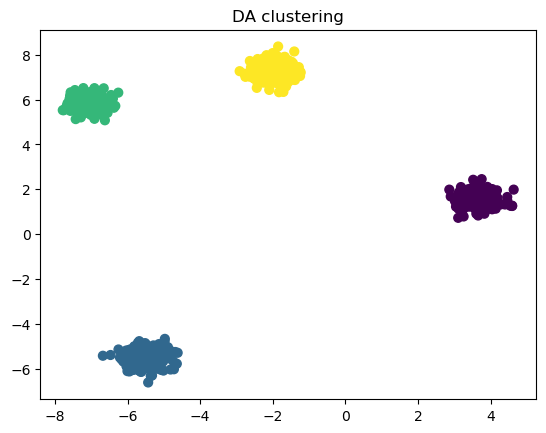

In [4]:
#from DA import DeterministicAnnealingClustering

DAC = DeterministicAnnealingClustering(n_clusters=n_clusters, random_state=ran_s)
DAC.fit(X_train)
y_DAC = DAC.predict(X_test)
y_DAC_hard = np.argmax(y_DAC, axis=1)
plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_DAC_hard, s=40, cmap='viridis')
plt.title("DA clustering")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.5
<span style=font-size:50%> Complete all problems in this section to get an additional (+0.5) point to the previous points. Note that you can have a maximum of 6 points at the end.</span>
</h2>

<p style="background-color:#adebad;">
    In this section we implement a plot which will help us better understand the DA method, and could also be a help for better debugging of your implementation.
    
 <ul style="background-color:#adebad;">
        <li> 
            Modify your implementation of <b>fit</b> function such that <b>plot_phase_diagram</b> method will produce a plot similar to the phase diagram plot shown in Figure 2 of the reference paper.
        </li>
</ul>  
</p>

<ul style="background-color:#adebad;">
            For this, extend DAC.fit to save the expected distortion during annealing as an additional attribute self.distortion.
            You might also want to save the number of effective clusters and the temperature along the way.
    </ul>
</p>

#### extend DAC.fit(self, X):
    # ...
    # Save information for each (n-th) annealing step:
    # self.distortion = [d0, d1, d2, ...]
    # self.n_eff_clusters = [e0, e1, e2, ...]
    # self.temp = [t0, t1, t2, ...]
    # ...

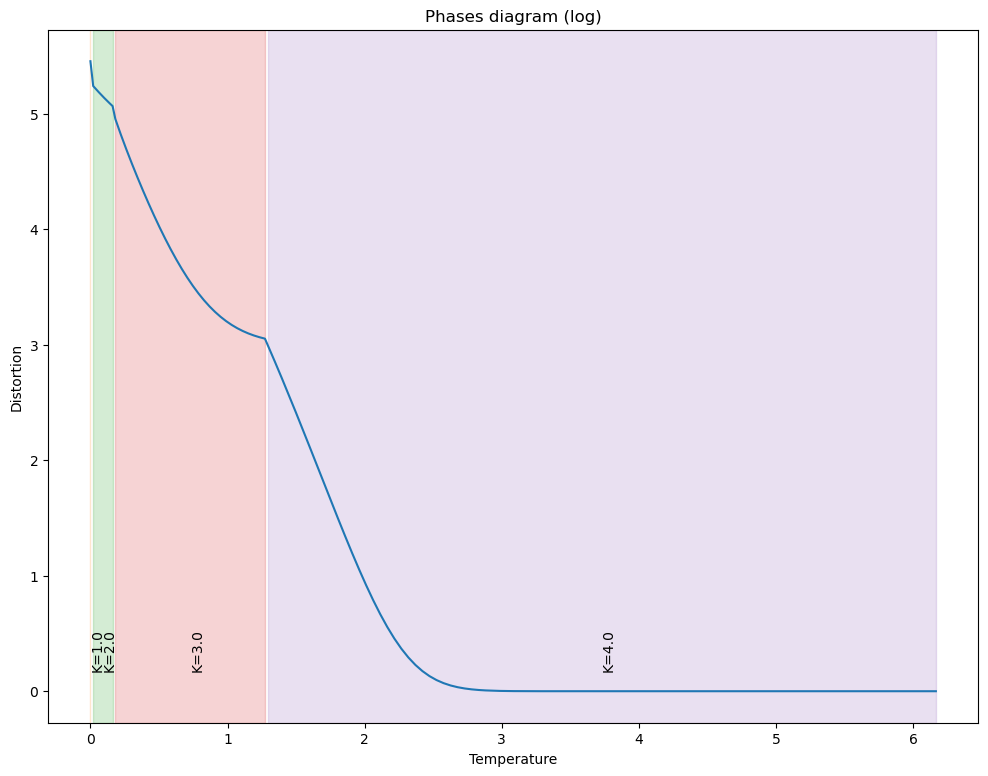

In [5]:
DAC.plot_phase_diagram()

<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this section to get an additional (+0.5) point to the previous points.</span>
</h2>
<ul style="background-color:#adebad;">
Here we implement another plot which helps better undetrstad the dynamics of the algorithm.
        <li>
        Implement DAC.plot_bifurcation, which should create a bifurcation plot.<br>
        Modify DAC.fit to keep track of the distances, using the tree object DAC.bifurcation_tree. When a cluster splits, it creates two child nodes. Each node should store its centroid vector, and the distance to the parent centroid vector. After splitting, the parent node is not updated anymore.<br>
        In the bifurcation plot, the horizontal distance of a child node to its parent node should be exactly the distance to the parent centroid vector. The two child nodes should move in opposite directions, i.e. one to the left of the parent and one to the right.
        </li>
</ul>

This section could bit a bit annoying, you can also jump to the next sections and come back here later. 

In [6]:
 #DAC.plot_bifurcation()

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this section to get an additional (+0.5) point to the previous points.</span>
</h2>

<p style="background-color:#adebad;">
Now we are ready to use some real world data. This might need some tweaking and handling of numberical instabilities. Please make sure your understand the data.
</p>

<p style="background-color:#adebad;">
Read the wine data [3], which contains 11 physiochemical attributes, and two labels (quality and color).
</p>

<p style="background-color:#adebad;">
    Create an instance of your DAC class with n_clusters = 2 and <b>fit the first 6000 samples</b> of the wine data set. Record the execution time. Furthermore, create an instance of the sklearn k-means class, and fit it with the same parameters. Again record the execution time. Make sure that the hyper parameters (initial temperature, min temperature, convergence criteria, noise, etc.) make sense and lead to a reasonable clustering
</p>

In [7]:
from DA import read_data_csv
X, y = read_data_csv("wine-data.csv", y_names=["quality", "color"])

X_train, X_test, y_train, y_test = train_test_split( X, y["color"], train_size=6000, random_state=42)

In [8]:
%%time
DAC = DeterministicAnnealingClustering(n_clusters=2, random_state=42, metric="euclidian", T_min=0.1, eta=0.98, epsilon = 0.1, T=1e-5)
DAC.fit(X_train)

free energy 13190.203389452006
CPU times: user 6.98 s, sys: 370 ms, total: 7.35 s
Wall time: 6.83 s


DeterministicAnnealingClustering(eta=0.95, n_clusters=2)

In [9]:
%%time
kmeans = cluster.KMeans(n_clusters=2,random_state=42)
kmeans.fit(X_train)

CPU times: user 232 ms, sys: 205 ms, total: 437 ms
Wall time: 78.7 ms


/opt/anaconda3/envs/slt-ce/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

In [10]:
%%time
y_kmeans = kmeans.predict(X_test)

CPU times: user 6.39 ms, sys: 10.6 ms, total: 17 ms
Wall time: 2.91 ms


In [11]:
%%time
y_DAC = DAC.predict(X_test)

CPU times: user 1.06 ms, sys: 1.97 ms, total: 3.03 ms
Wall time: 478 µs


<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this section to get an additional (+0.5) point to the previous points.</span>
</h2>
<ul style="background-color:#adebad;">
<li> Before we can compute the confusion matrix, we need to perform some post-processing on the DAC cluster assignments.
    Explain what the function postprocess (defined below) does, and why we need it. To do so, complete the docstring of the function postprocess.
        </li>
</ul>

In [12]:
def postprocess(y_DAC, y_kmeans):
    """ input :
- the output probabilities of the DAC algorithm y_DAC
- the labels assigned by K-Means to each cluster : y_kmeans 

The function first extracts the cluster with the highest probability for each sample in y_DAC.

Next, it finds the number of clusters present in y_DAC_hard.

Then, for each cluster in y_DAC_hard, it finds the sample with the highest probability for that cluster and appends the corresponding label from y_kmeans to a list called dac2kmeans.

After that, it constructs a new list y_DAC_new by mapping each cluster label in y_DAC_hard to its corresponding K-Means label from dac2kmeans.

Finally, it returns the new list y_DAC_new which contains the final cluster labels after mapping the DAC labels to K-Means labels. 
    """
    y_DAC_hard = np.argmax(y_DAC, axis=1)
    
    n_clusters = len(np.unique(y_DAC_hard))
    dac2kmeans = []
    for cluster in range(n_clusters):
        argmax = np.argmax(y_DAC[:, cluster])
        dac2kmeans.append(y_kmeans[argmax])
        
    y_DAC_new = []
    for dac_label in y_DAC_hard:
        y_DAC_new.append(dac2kmeans[dac_label])
        
    return np.array(y_DAC_new)

In [13]:
skl.metrics.confusion_matrix(y_kmeans, postprocess(y_DAC, y_kmeans))

array([[287,   1],
       [  0, 209]])

</h2>

<ul style="background-color:#adebad;">
        <li> Read the docstring of <b>transform method</b> and understand what it does.
        </li>
        <li>
        Use DAC.transform and kmeans.transform to transform both, X_train and X_test. 
        </li>
       
</ul>

In [14]:
X_train_DAC = DAC.transform(X_train)
X_test_DAC = DAC.transform(X_test)

X_train_kmeans = kmeans.transform(X_train)
X_test_kmeans = kmeans.transform(X_test)

<ul style="background-color:#adebad;">
        <li>
        Fit an SVM classifier with default parameters to the untransformed data, and to the transformed data.
        Compare the performance of predicting whether the color of a wine is red or white.
        </li>
    </ul>

In [15]:
svm = svm.SVC(random_state=42)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

/opt/anaconda3/envs/slt-ce/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9275653923541247

In [16]:
#svm_DAC = svm.SVC(random_state=42)
#svm_DAC.fit(X_train_DAC, y_train)
#svm_DAC.score(X_test_DAC, y_test)

In [17]:
#svm = svm.SVC(random_state=42)
#svm.fit(X_train_kmeans, y_train)
#svm.score(X_test_kmeans, y_test)

<ul style="background-color:#adebad;">
        <li>
        Produce two scatter plots, one for X_train_DAC and one for X_train_kmeans.<br>
        Make the marker color indicate the wine color.
        </li>
    </ul>

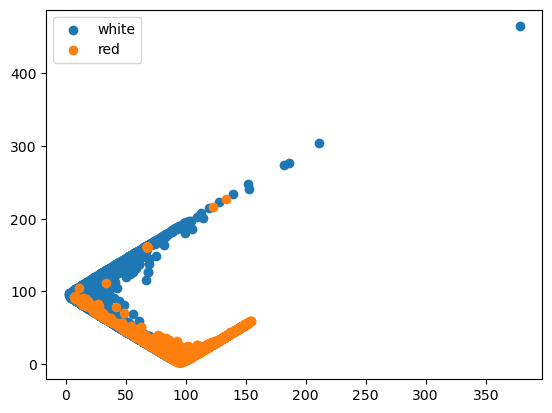

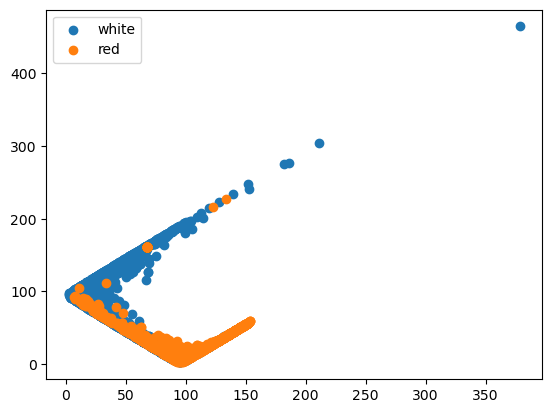

In [18]:
plt.figure()
plt.scatter( X_train_DAC[np.where(np.array(y_train)=='white'), 0],X_train_DAC[np.where(np.array(y_train)=='white'), 1], label='white')
plt.scatter( X_train_DAC[np.where(np.array(y_train)=='red'), 0], X_train_DAC[np.where(np.array(y_train)=='red'), 1], label='red')
plt.legend()
plt.figure()
plt.scatter(X_train_kmeans[np.where(np.array(y_train)=='white'), 0], X_train_kmeans[np.where(np.array(y_train)=='white'), 1], label='white')
plt.scatter(X_train_kmeans[np.where(np.array(y_train)=='red'), 0], X_train_kmeans[np.where(np.array(y_train)=='red'), 1], label='red')
plt.legend()
plt.show()

<ul style="background-color:#adebad;">
    <li>
        Create a fixed 2D embedding (e.g. with LLE, t-SNE, MDS) of the wine data and color the markers according to quality and color. Fit and transform X_train with DAC(n_clusters=2,3,4,5,6,7,8,...). Produce a plot of the SVM score svm_DAC.score(X_test_DAC, y_test) as a function of n_clusters.. Each time use marker shapes to display the cluster memberships, and compare to the labels color and quality.
    </li>
</ul>

In [19]:
"""
    %%time
    lle = skl.manifold.LocallyLinearEmbedding(random_state=...)
    lle.fit(...)
"""

'\n    %%time\n    lle = skl.manifold.LocallyLinearEmbedding(random_state=...)\n    lle.fit(...)\n'

<ul style="background-color:#adebad;">
        <li>
            So far, our implementation of DAC assumed that our data is compatible with the euclidian metric. Argue why this assumption is not justified for the wine-data. Suggest a better alternative (no implementation required!).
        </li>
    </ul>
</p>



The assumption that the wine dataset is compatible with the Euclidean metric is not justified because the columns of the dataset are not on the same scales for example citric_acid, residual_sugar, density and pH are on totally different scales.

Using the Euclidean metric without processing the features may lead to some features dominating the distance calculations due to their larger scale or range. This can result in an inaccurate representation of the actual similarities between the data points.

To solve this problem, we can scale or standardize data before such that all features have a range between 0 and 1 for example and then use th euclidean metric on the transformed variables. 

